In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from sklearn import metrics
import numpy as np
import pandas as pd
from collections import OrderedDict
from manifold_helper import ManifoldHelper


rng = np.random.default_rng(seed=42)

def plot_images(data, n_img_per_row=10, cmap='gray'):
    # plot images of MNIST base
    shape = int(np.sqrt(len(data[0])))
    # plot iage of the digits
    img = np.zeros( (shape * n_img_per_row, shape * n_img_per_row) )
    for i in range( n_img_per_row ):
        ix = shape * i
        for j in range( n_img_per_row ):
            iy = shape * j
            img[ix:ix + shape, iy:iy + shape] = data[i * n_img_per_row + j].reshape( (shape, shape) )

    plt.figure(figsize=(15, 15))
    plt.imshow( img, cmap=cmap )
    plt.xticks( [] )
    plt.yticks( [] )
    plt.show()

In [2]:
n_class = 10 # n primeiros digitos
amostras = 3000
neighbors = [5, 8, 10, 12]
dimensions = [2, 3, 5, 10, 25, 50, 100]
methods = ['ISOMAP', 'LLE', 'SE', 'LTSA']

# Carregando os dados

In [3]:
datasetOriginal = pd.read_csv("data/mnist_train.csv")
df = datasetOriginal.copy()
df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB


In [5]:
# separar os rótulos dos dados
label, x = df.iloc[:, :1], df.iloc[:, 1:]
label = label.to_numpy().transpose()[0]
x = x.to_numpy()
label, x

(array([5, 0, 4, ..., 5, 6, 8], dtype=int64),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64))

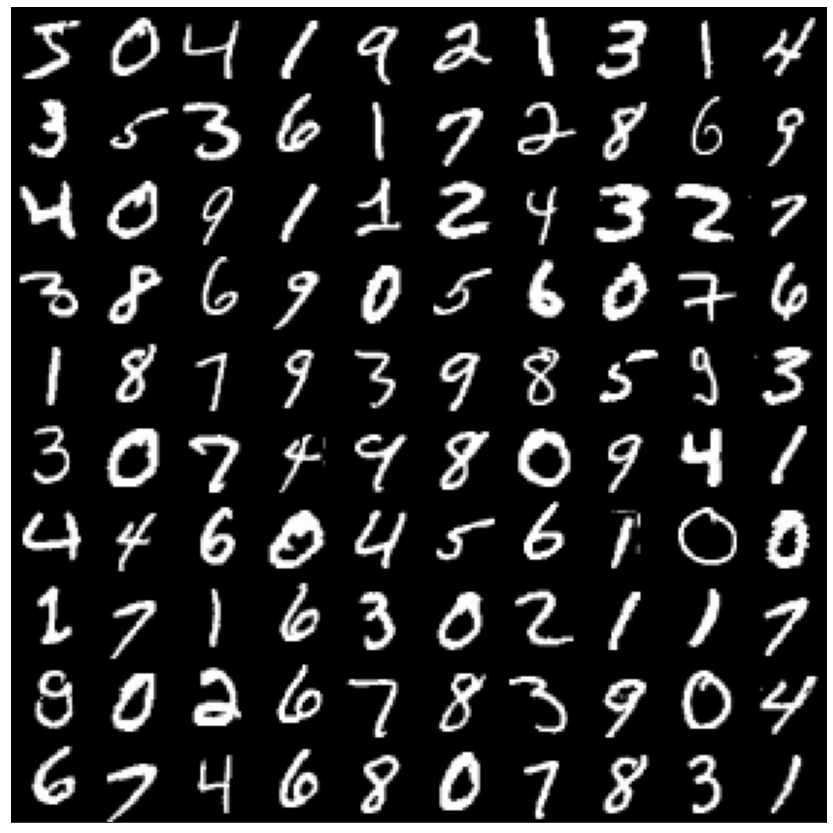

In [6]:
plot_images(x)

## Selecionando dados para analise

In [7]:
idx = np.argsort(label)
label = label[idx]
x = x[idx]

idx = np.random.RandomState(seed=42).permutation(len(x))
x = x[idx, :]
label = label[idx]
x_cut = x[:amostras, :]
label_cut = label[:amostras]

unique, counts = np.unique(label_cut, return_counts=True)
num_data_cut = dict(zip(unique, counts))
print(x_cut.shape)
num_data_cut

(3000, 784)


{0: 286,
 1: 353,
 2: 274,
 3: 316,
 4: 289,
 5: 290,
 6: 306,
 7: 307,
 8: 290,
 9: 289}

# ARI

Gerando os métodos para cada valor de vizinhos no intervalo

In [8]:
manifold = ManifoldHelper(neighbors, dimensions, methods, alternative_LTSA=True)

Using alternative LTSA.


In [9]:
ari_results = manifold.evaluate_all(x_cut, label_cut, n_components=n_class)


2_dimension:
   5_neighbors: 0.32(3.4s)  0.40(0.7s)  0.39(0.5s)  -0.00(17.2s) 
   8_neighbors: 0.27(3.8s)  0.40(1.3s)  0.39(0.7s)  0.24(17.1s) 
   10_neighbors: 0.30(4.1s)  0.35(1.4s)  0.36(0.8s)  0.30(17.2s) 
   12_neighbors: 0.29(4.3s)  0.38(1.3s)  0.36(0.7s)  0.36(17.5s) 
3_dimension:
   5_neighbors: 0.31(3.4s)  0.44(0.7s)  0.45(0.5s)  -1.00(-1.0s) 
   8_neighbors: 0.28(3.8s)  0.43(1.3s)  0.44(0.6s)  0.00(17.1s) 
   10_neighbors: 0.28(4.1s)  0.41(1.4s)  0.47(0.7s)  0.27(17.3s) 
   12_neighbors: 0.28(4.3s)  0.41(1.3s)  0.44(0.7s)  0.36(17.2s) 
5_dimension:
   5_neighbors: 0.52(3.4s)  0.48(0.7s)  0.50(0.4s)  -1.00(-1.0s) 
   8_neighbors: 0.45(3.8s)  0.44(1.3s)  0.50(0.6s)  0.00(16.2s) 
   10_neighbors: 0.40(4.1s)  0.37(1.4s)  0.50(0.7s)  0.35(17.0s) 
   12_neighbors: 0.50(4.3s)  0.35(1.3s)  0.50(0.7s)  0.38(17.5s) 
10_dimension:
   5_neighbors: 0.52(4.4s)  0.49(1.5s)  0.65(0.5s)  -1.00(-1.0s) 
   8_neighbors: 0.56(4.7s)  0.45(1.5s)  0.62(0.6s)  -1.00(-1.0s) 
   10_neighbors: 0.57(5.0

In [10]:
manifold.evaluate_gmm_ari(x_cut, label_cut, n_class)

0.36818783331318994

In [11]:
random_label = np.random.default_rng(42).integers(0, n_class, size=len(x_cut))
random_ari = metrics.adjusted_rand_score(random_label, label_cut)
print(f'ARI com labels randômicos: {random_ari:.2f}')

ARI com labels randômicos: -0.00


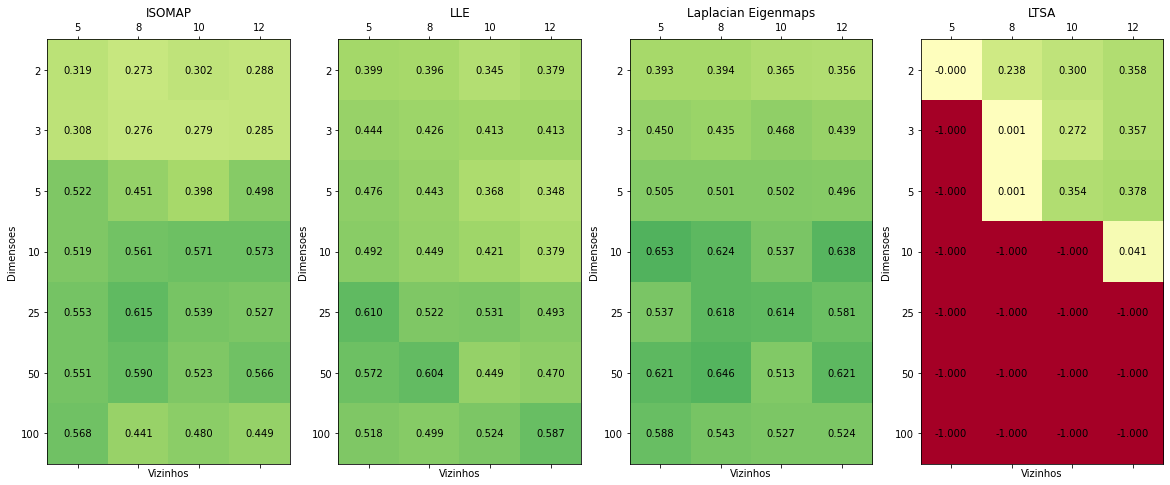

In [12]:
manifold.plot_ari_results(ari_results, neighbors, dimensions)

In [21]:
for m in methods:
    ari_max = np.max(ari_results[m])
    row, col = np.unravel_index(np.argmax(ari_results[m], axis=None), ari_results[m].shape)
    k = neighbors[col]
    d = dimensions[row]
    print(f'{m}: max = {ari_max:.2f} in ({k}, {d})')

ISOMAP: max = 0.61 in (8, 25)
LLE: max = 0.61 in (5, 25)
SE: max = 0.65 in (5, 10)
LTSA: max = 0.38 in (12, 5)


# Testes com várias quantidades de imagens

In [22]:
manifold = ManifoldHelper()

amostras = np.arange(1000, 12001, 1000)
methods = ['ISOMAP', 'LLE', 'SE', 'LTSA']
ari_results = OrderedDict()
time_results = OrderedDict()
for m in methods:
    ari_results[m] = np.zeros(len(amostras))
    time_results[m] = np.zeros(len(amostras))
    
for i in range(len(amostras)):
    x_cut = x[:amostras[i], :]
    label_cut = label[:amostras[i]]
    
    print(f'Amostras: {amostras[i]}')
    
    # ISOMAP: k = 8 e d = 25
    ari_results['ISOMAP'][i], time_results['ISOMAP'][i] = manifold._evaluate_method(x_cut, label_cut, 'ISOMAP', 8, 25, n_components=10)
    # LLE: k = 5 e d = 25
    ari_results['LLE'][i], time_results['LLE'][i] = manifold._evaluate_method(x_cut, label_cut, 'LLE', 5, 25, n_components=10)
    # Laplacian Eigenmaps: k = 5 e d = 10
    ari_results['SE'][i], time_results['SE'][i] = manifold._evaluate_method(x_cut, label_cut, 'SE', 5, 10, n_components=10)
    # LTSA: k = 12 e d = 5
    ari_results['LTSA'][i], time_results['LTSA'][i] = manifold._evaluate_method(x_cut, label_cut, 'SE', 12, 5, n_components=10)

Using alternative LTSA.
Amostras: 1000
Amostras: 2000
Amostras: 3000
Amostras: 4000
Amostras: 5000
Amostras: 6000
Amostras: 7000
Amostras: 8000
Amostras: 9000
Amostras: 10000
Amostras: 11000
Amostras: 12000


In [79]:
def plot_ari_results_time(ari_results, method, title, color, marker):
    fig, ax1 = plt.subplots()
    plt.xticks(amostras, rotation=45, ha='center')
    plt.title(title)

    ax1.set_xlabel('Amostras (n)')
    ax1.set_ylabel('Adjusted Rand Index')
    ax1.plot(amostras, ari_results[method], color=color, marker=marker, label='ARI')
    ax1.set_yticks(np.arange(0, 1.01, 0.1))
    ax1.grid()

    ax2 = ax1.twinx()
    color = '#000000'
    ax2.set_ylabel('Tempo (s)', color=color)
    ax2.plot(amostras, time_results[method], color=color, marker='s', linestyle='dashed', label='Tempo')
    ax2.tick_params(axis='y', labelcolor=color)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    fig.tight_layout()
    plt.show()

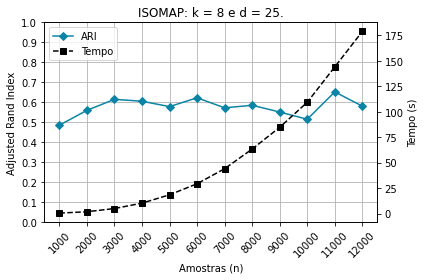

In [85]:
plot_ari_results_time(ari_results, 'ISOMAP', 'ISOMAP: k = 8 e d = 25', '#0b84a5', '*')

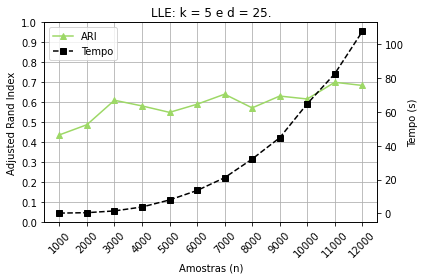

In [86]:
plot_ari_results_time(ari_results, 'LLE', 'LLE: k = 5 e d = 25.', '#9dd866', '^')

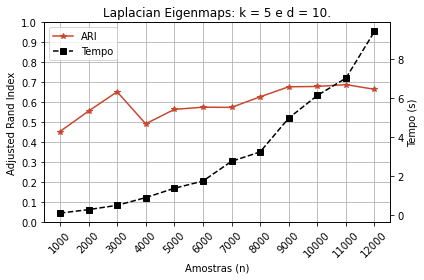

In [87]:
plot_ari_results_time(ari_results, 'SE', 'Laplacian Eigenmaps: k = 5 e d = 10.', '#ca472f', 'D')

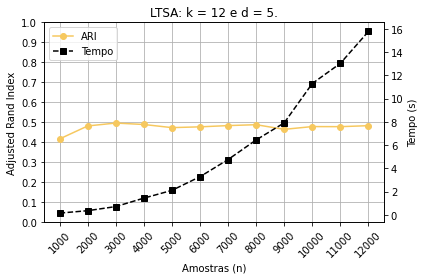

In [88]:
plot_ari_results_time(ari_results, 'LTSA', 'LTSA: k = 12 e d = 5.', '#f6c85f', 'o')

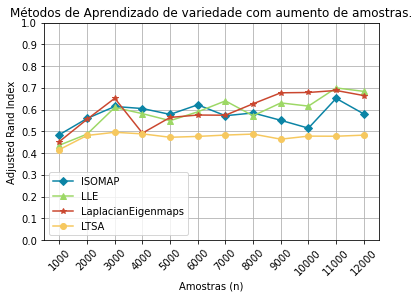

In [96]:
fig, ax1 = plt.subplots()
plt.xticks(amostras, rotation=45, ha='center')
plt.title('Métodos de Aprendizado de variedade com aumento de amostras.')
    
ax1.set_xlabel('Amostras (n)')
ax1.set_ylabel('Adjusted Rand Index')

ax1.plot(amostras, ari_results['ISOMAP'], color='#0b84a5',marker='*', label='ISOMAP')
ax1.plot(amostras, ari_results['LLE'], color='#9dd866', marker='^', label='LLE')
ax1.plot(amostras, ari_results['SE'], color='#ca472f', marker='D', label='LaplacianEigenmaps')
ax1.plot(amostras, ari_results['LTSA'], color='#f6c85f', marker='o', label='LTSA')
ax1.set_yticks(np.arange(0, 1.01, 0.1))

plt.legend(loc=3)
plt.grid()
plt.show()

In [100]:
ari_media = OrderedDict()
for m in methods:
    ari_media[m] = np.mean(ari_results[m])
ari_media

OrderedDict([('ISOMAP', 0.5769738455120837),
             ('LLE', 0.5918816238395609),
             ('SE', 0.600652853432749),
             ('LTSA', 0.475853584739794)])